# Column generation approach

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import cg, config, dataset, layers, pack, superitems, utils, warm_start

In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Dataset

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

In [11]:
ordered_products = 500
order = product_dataset.get_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,47837,288,97,331,2,9246816
1,518349,283,356,395,2,39795460
2,784838,166,133,298,21,6579244
3,797968,287,146,447,6,18730194
4,552829,399,136,682,2,37008048


<IPython.core.display.Javascript object>

In [6]:
order = pd.concat([order.sample(4)] * 5).reset_index(drop=True)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,54886,249,142,388,3,13718904
3,644167,286,158,481,6,21735428
4,121958,193,221,371,2,15824263


<IPython.core.display.Javascript object>

In [18]:
order = order.sample(100).reset_index(drop=True)
order["height"] = 400
order.head()

ValueError: Cannot take a larger sample than population when 'replace=False'

<IPython.core.display.Javascript object>

## Martello's lower bounds

In [125]:
utils.get_l0_lb(order, config.PALLET_DIMS)

9.0

<IPython.core.display.Javascript object>

In [126]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [10]:
utils.get_l2_lb(order, config.PALLET_DIMS)

TypeError: get_l1_lb() takes 2 positional arguments but 4 were given

<IPython.core.display.Javascript object>

## Superitems

In [7]:
superitems_pool = superitems.SuperitemPool(
    order=order, pallet_dims=config.PALLET_DIMS, max_vstacked=4, not_horizontal=True
)
superitems_pool.to_dataframe()

Generating vertical superitems: 100%|██████████| 27/27 [00:00<00:00, 190010.42it/s]


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,220,213,312,[1],SingleItemSuperitem
2,273,228,405,[2],SingleItemSuperitem
3,271,167,350,[3],SingleItemSuperitem
4,251,181,349,[4],SingleItemSuperitem
...,...,...,...,...,...
196,191,288,1075,"[8, 51, 66, 72]",VerticalSuperitem
197,203,313,1295,"[11, 63, 70, 77]",VerticalSuperitem
198,235,304,1104,"[32, 36, 69, 89]",VerticalSuperitem
199,234,320,1656,"[19, 30, 40, 99]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [37]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Vertical")]

,width,depth,height,ids,type
100,151,141,516,"[49, 73]",VerticalSuperitem
101,160,111,525,"[16, 75]",VerticalSuperitem
102,176,155,503,"[55, 65]",VerticalSuperitem
103,177,175,537,"[78, 91]",VerticalSuperitem
104,178,174,421,"[15, 24]",VerticalSuperitem
...,...,...,...,...,...
201,196,242,1053,"[11, 74, 77, 89]",VerticalSuperitem
202,222,269,1222,"[44, 67, 79, 95]",VerticalSuperitem
203,237,291,1306,"[13, 38, 69, 84]",VerticalSuperitem
204,268,318,1589,"[2, 23, 40, 41]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [9]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Horizontal")]

,width,depth,height,ids,type


<IPython.core.display.Javascript object>

## Height groups

In [10]:
height_groups = warm_start.get_height_groups(
    superitems_pool, config.PALLET_DIMS, height_tol=50, density_tol=0.5
)
for group in height_groups:
    display(group.to_dataframe())

,width,depth,height,ids,type
0,191,80,250,[18],SingleItemSuperitem
1,142,168,255,[31],SingleItemSuperitem
2,190,304,233,[32],SingleItemSuperitem
3,191,252,269,[51],SingleItemSuperitem
4,219,173,257,[55],SingleItemSuperitem
5,144,115,262,[58],SingleItemSuperitem
6,206,150,219,[59],SingleItemSuperitem
7,179,131,252,[64],SingleItemSuperitem
8,170,288,230,[66],SingleItemSuperitem
9,212,259,265,[69],SingleItemSuperitem


,width,depth,height,ids,type
0,191,80,250,[18],SingleItemSuperitem
1,142,168,255,[31],SingleItemSuperitem
2,190,304,233,[32],SingleItemSuperitem
3,191,252,269,[51],SingleItemSuperitem
4,219,173,257,[55],SingleItemSuperitem
5,144,115,262,[58],SingleItemSuperitem
6,179,131,252,[64],SingleItemSuperitem
7,170,288,230,[66],SingleItemSuperitem
8,212,259,265,[69],SingleItemSuperitem
9,203,258,237,[70],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,176,163,297,[5],SingleItemSuperitem
2,176,162,296,[12],SingleItemSuperitem
3,191,80,250,[18],SingleItemSuperitem
4,142,168,255,[31],SingleItemSuperitem
5,205,129,299,[34],SingleItemSuperitem
6,191,252,269,[51],SingleItemSuperitem
7,219,173,257,[55],SingleItemSuperitem
8,223,124,299,[57],SingleItemSuperitem
9,144,115,262,[58],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,176,163,297,[5],SingleItemSuperitem
2,176,162,296,[12],SingleItemSuperitem
3,142,168,255,[31],SingleItemSuperitem
4,205,129,299,[34],SingleItemSuperitem
5,235,242,303,[36],SingleItemSuperitem
6,191,252,269,[51],SingleItemSuperitem
7,219,173,257,[55],SingleItemSuperitem
8,223,124,299,[57],SingleItemSuperitem
9,144,115,262,[58],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,176,163,297,[5],SingleItemSuperitem
2,176,162,296,[12],SingleItemSuperitem
3,205,129,299,[34],SingleItemSuperitem
4,235,242,303,[36],SingleItemSuperitem
5,219,320,306,[40],SingleItemSuperitem
6,191,252,269,[51],SingleItemSuperitem
7,219,173,257,[55],SingleItemSuperitem
8,223,124,299,[57],SingleItemSuperitem
9,144,115,262,[58],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,176,163,297,[5],SingleItemSuperitem
2,186,224,308,[8],SingleItemSuperitem
3,176,162,296,[12],SingleItemSuperitem
4,205,129,299,[34],SingleItemSuperitem
5,235,242,303,[36],SingleItemSuperitem
6,219,320,306,[40],SingleItemSuperitem
7,191,252,269,[51],SingleItemSuperitem
8,223,124,299,[57],SingleItemSuperitem
9,144,115,262,[58],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,220,213,312,[1],SingleItemSuperitem
2,176,163,297,[5],SingleItemSuperitem
3,186,224,308,[8],SingleItemSuperitem
4,219,85,312,[10],SingleItemSuperitem
5,176,162,296,[12],SingleItemSuperitem
6,205,129,299,[34],SingleItemSuperitem
7,235,242,303,[36],SingleItemSuperitem
8,219,320,306,[40],SingleItemSuperitem
9,191,252,269,[51],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,220,213,312,[1],SingleItemSuperitem
2,176,163,297,[5],SingleItemSuperitem
3,186,224,308,[8],SingleItemSuperitem
4,219,85,312,[10],SingleItemSuperitem
5,176,162,296,[12],SingleItemSuperitem
6,205,129,299,[34],SingleItemSuperitem
7,235,242,303,[36],SingleItemSuperitem
8,255,96,319,[39],SingleItemSuperitem
9,219,320,306,[40],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,220,213,312,[1],SingleItemSuperitem
2,176,163,297,[5],SingleItemSuperitem
3,186,224,308,[8],SingleItemSuperitem
4,219,85,312,[10],SingleItemSuperitem
5,176,162,296,[12],SingleItemSuperitem
6,243,370,331,[29],SingleItemSuperitem
7,205,129,299,[34],SingleItemSuperitem
8,235,242,303,[36],SingleItemSuperitem
9,255,96,319,[39],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,220,213,312,[1],SingleItemSuperitem
2,176,163,297,[5],SingleItemSuperitem
3,186,224,308,[8],SingleItemSuperitem
4,219,85,312,[10],SingleItemSuperitem
5,192,277,344,[11],SingleItemSuperitem
6,176,162,296,[12],SingleItemSuperitem
7,263,142,345,[27],SingleItemSuperitem
8,224,144,343,[28],SingleItemSuperitem
9,243,370,331,[29],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,220,213,312,[1],SingleItemSuperitem
2,176,163,297,[5],SingleItemSuperitem
3,186,224,308,[8],SingleItemSuperitem
4,219,85,312,[10],SingleItemSuperitem
5,192,277,344,[11],SingleItemSuperitem
6,176,162,296,[12],SingleItemSuperitem
7,248,224,346,[21],SingleItemSuperitem
8,263,142,345,[27],SingleItemSuperitem
9,224,144,343,[28],SingleItemSuperitem


,width,depth,height,ids,type
0,177,162,298,[0],SingleItemSuperitem
1,220,213,312,[1],SingleItemSuperitem
2,265,264,348,[6],SingleItemSuperitem
3,186,224,308,[8],SingleItemSuperitem
4,219,85,312,[10],SingleItemSuperitem
5,192,277,344,[11],SingleItemSuperitem
6,248,224,346,[21],SingleItemSuperitem
7,263,142,345,[27],SingleItemSuperitem
8,224,144,343,[28],SingleItemSuperitem
9,243,370,331,[29],SingleItemSuperitem


,width,depth,height,ids,type
0,220,213,312,[1],SingleItemSuperitem
1,251,181,349,[4],SingleItemSuperitem
2,265,264,348,[6],SingleItemSuperitem
3,186,224,308,[8],SingleItemSuperitem
4,219,85,312,[10],SingleItemSuperitem
5,192,277,344,[11],SingleItemSuperitem
6,248,224,346,[21],SingleItemSuperitem
7,263,142,345,[27],SingleItemSuperitem
8,224,144,343,[28],SingleItemSuperitem
9,243,370,331,[29],SingleItemSuperitem


,width,depth,height,ids,type
0,220,213,312,[1],SingleItemSuperitem
1,271,167,350,[3],SingleItemSuperitem
2,251,181,349,[4],SingleItemSuperitem
3,265,264,348,[6],SingleItemSuperitem
4,186,224,308,[8],SingleItemSuperitem
5,219,85,312,[10],SingleItemSuperitem
6,192,277,344,[11],SingleItemSuperitem
7,248,224,346,[21],SingleItemSuperitem
8,263,142,345,[27],SingleItemSuperitem
9,224,144,343,[28],SingleItemSuperitem


,width,depth,height,ids,type
0,220,213,312,[1],SingleItemSuperitem
1,271,167,350,[3],SingleItemSuperitem
2,251,181,349,[4],SingleItemSuperitem
3,265,264,348,[6],SingleItemSuperitem
4,186,224,308,[8],SingleItemSuperitem
5,219,85,312,[10],SingleItemSuperitem
6,192,277,344,[11],SingleItemSuperitem
7,248,224,346,[21],SingleItemSuperitem
8,263,142,345,[27],SingleItemSuperitem
9,224,144,343,[28],SingleItemSuperitem


,width,depth,height,ids,type
0,220,213,312,[1],SingleItemSuperitem
1,271,167,350,[3],SingleItemSuperitem
2,251,181,349,[4],SingleItemSuperitem
3,265,264,348,[6],SingleItemSuperitem
4,186,224,308,[8],SingleItemSuperitem
5,219,85,312,[10],SingleItemSuperitem
6,192,277,344,[11],SingleItemSuperitem
7,248,224,346,[21],SingleItemSuperitem
8,263,142,345,[27],SingleItemSuperitem
9,224,144,343,[28],SingleItemSuperitem


,width,depth,height,ids,type
0,220,213,312,[1],SingleItemSuperitem
1,271,167,350,[3],SingleItemSuperitem
2,251,181,349,[4],SingleItemSuperitem
3,265,264,348,[6],SingleItemSuperitem
4,219,85,312,[10],SingleItemSuperitem
5,192,277,344,[11],SingleItemSuperitem
6,219,413,362,[16],SingleItemSuperitem
7,248,224,346,[21],SingleItemSuperitem
8,263,142,345,[27],SingleItemSuperitem
9,224,144,343,[28],SingleItemSuperitem


,width,depth,height,ids,type
0,271,167,350,[3],SingleItemSuperitem
1,251,181,349,[4],SingleItemSuperitem
2,265,264,348,[6],SingleItemSuperitem
3,192,277,344,[11],SingleItemSuperitem
4,219,413,362,[16],SingleItemSuperitem
5,248,224,346,[21],SingleItemSuperitem
6,263,142,345,[27],SingleItemSuperitem
7,224,144,343,[28],SingleItemSuperitem
8,243,370,331,[29],SingleItemSuperitem
9,234,288,359,[30],SingleItemSuperitem


,width,depth,height,ids,type
0,271,167,350,[3],SingleItemSuperitem
1,251,181,349,[4],SingleItemSuperitem
2,265,264,348,[6],SingleItemSuperitem
3,192,277,344,[11],SingleItemSuperitem
4,219,413,362,[16],SingleItemSuperitem
5,248,224,346,[21],SingleItemSuperitem
6,263,142,345,[27],SingleItemSuperitem
7,224,144,343,[28],SingleItemSuperitem
8,243,370,331,[29],SingleItemSuperitem
9,234,288,359,[30],SingleItemSuperitem


,width,depth,height,ids,type
0,271,167,350,[3],SingleItemSuperitem
1,251,181,349,[4],SingleItemSuperitem
2,265,264,348,[6],SingleItemSuperitem
3,192,277,344,[11],SingleItemSuperitem
4,219,413,362,[16],SingleItemSuperitem
5,248,224,346,[21],SingleItemSuperitem
6,206,184,382,[23],SingleItemSuperitem
7,263,142,345,[27],SingleItemSuperitem
8,224,144,343,[28],SingleItemSuperitem
9,234,288,359,[30],SingleItemSuperitem


,width,depth,height,ids,type
0,271,167,350,[3],SingleItemSuperitem
1,251,181,349,[4],SingleItemSuperitem
2,265,264,348,[6],SingleItemSuperitem
3,192,277,344,[11],SingleItemSuperitem
4,245,325,385,[14],SingleItemSuperitem
5,219,413,362,[16],SingleItemSuperitem
6,248,224,346,[21],SingleItemSuperitem
7,206,184,382,[23],SingleItemSuperitem
8,263,142,345,[27],SingleItemSuperitem
9,224,144,343,[28],SingleItemSuperitem


,width,depth,height,ids,type
0,271,167,350,[3],SingleItemSuperitem
1,251,181,349,[4],SingleItemSuperitem
2,265,264,348,[6],SingleItemSuperitem
3,245,325,385,[14],SingleItemSuperitem
4,219,413,362,[16],SingleItemSuperitem
5,265,196,398,[22],SingleItemSuperitem
6,206,184,382,[23],SingleItemSuperitem
7,234,288,359,[30],SingleItemSuperitem
8,290,178,379,[38],SingleItemSuperitem
9,263,271,376,[41],SingleItemSuperitem


,width,depth,height,ids,type
0,245,325,385,[14],SingleItemSuperitem
1,219,413,362,[16],SingleItemSuperitem
2,265,196,398,[22],SingleItemSuperitem
3,206,184,382,[23],SingleItemSuperitem
4,234,288,359,[30],SingleItemSuperitem
5,290,178,379,[38],SingleItemSuperitem
6,263,271,376,[41],SingleItemSuperitem
7,299,173,402,[43],SingleItemSuperitem
8,252,335,377,[44],SingleItemSuperitem
9,260,153,387,[47],SingleItemSuperitem


,width,depth,height,ids,type
0,273,228,405,[2],SingleItemSuperitem
1,245,325,385,[14],SingleItemSuperitem
2,219,413,362,[16],SingleItemSuperitem
3,265,196,398,[22],SingleItemSuperitem
4,206,184,382,[23],SingleItemSuperitem
5,234,288,359,[30],SingleItemSuperitem
6,290,178,379,[38],SingleItemSuperitem
7,263,271,376,[41],SingleItemSuperitem
8,299,173,402,[43],SingleItemSuperitem
9,252,335,377,[44],SingleItemSuperitem


,width,depth,height,ids,type
0,273,228,405,[2],SingleItemSuperitem
1,279,242,412,[7],SingleItemSuperitem
2,245,325,385,[14],SingleItemSuperitem
3,219,413,362,[16],SingleItemSuperitem
4,265,196,398,[22],SingleItemSuperitem
5,206,184,382,[23],SingleItemSuperitem
6,290,178,379,[38],SingleItemSuperitem
7,263,271,376,[41],SingleItemSuperitem
8,299,173,402,[43],SingleItemSuperitem
9,252,335,377,[44],SingleItemSuperitem


,width,depth,height,ids,type
0,273,228,405,[2],SingleItemSuperitem
1,279,242,412,[7],SingleItemSuperitem
2,245,325,385,[14],SingleItemSuperitem
3,265,196,398,[22],SingleItemSuperitem
4,206,184,382,[23],SingleItemSuperitem
5,290,178,379,[38],SingleItemSuperitem
6,263,271,376,[41],SingleItemSuperitem
7,269,85,413,[42],SingleItemSuperitem
8,299,173,402,[43],SingleItemSuperitem
9,252,335,377,[44],SingleItemSuperitem


,width,depth,height,ids,type
0,273,228,405,[2],SingleItemSuperitem
1,279,242,412,[7],SingleItemSuperitem
2,245,325,385,[14],SingleItemSuperitem
3,265,196,398,[22],SingleItemSuperitem
4,206,184,382,[23],SingleItemSuperitem
5,290,178,379,[38],SingleItemSuperitem
6,263,271,376,[41],SingleItemSuperitem
7,269,85,413,[42],SingleItemSuperitem
8,299,173,402,[43],SingleItemSuperitem
9,252,335,377,[44],SingleItemSuperitem


,width,depth,height,ids,type
0,273,228,405,[2],SingleItemSuperitem
1,279,242,412,[7],SingleItemSuperitem
2,245,325,385,[14],SingleItemSuperitem
3,265,196,398,[22],SingleItemSuperitem
4,206,184,382,[23],SingleItemSuperitem
5,290,178,379,[38],SingleItemSuperitem
6,269,85,413,[42],SingleItemSuperitem
7,299,173,402,[43],SingleItemSuperitem
8,252,335,377,[44],SingleItemSuperitem
9,332,178,417,[46],SingleItemSuperitem


,width,depth,height,ids,type
0,273,228,405,[2],SingleItemSuperitem
1,279,242,412,[7],SingleItemSuperitem
2,245,325,385,[14],SingleItemSuperitem
3,320,50,428,[17],SingleItemSuperitem
4,265,196,398,[22],SingleItemSuperitem
5,206,184,382,[23],SingleItemSuperitem
6,290,178,379,[38],SingleItemSuperitem
7,269,85,413,[42],SingleItemSuperitem
8,299,173,402,[43],SingleItemSuperitem
9,332,178,417,[46],SingleItemSuperitem


,width,depth,height,ids,type
0,273,228,405,[2],SingleItemSuperitem
1,279,242,412,[7],SingleItemSuperitem
2,245,325,385,[14],SingleItemSuperitem
3,320,50,428,[17],SingleItemSuperitem
4,265,196,398,[22],SingleItemSuperitem
5,206,184,382,[23],SingleItemSuperitem
6,269,85,413,[42],SingleItemSuperitem
7,299,173,402,[43],SingleItemSuperitem
8,332,178,417,[46],SingleItemSuperitem
9,260,153,387,[47],SingleItemSuperitem


,width,depth,height,ids,type
0,273,228,405,[2],SingleItemSuperitem
1,279,242,412,[7],SingleItemSuperitem
2,277,210,448,[13],SingleItemSuperitem
3,320,50,428,[17],SingleItemSuperitem
4,203,295,447,[19],SingleItemSuperitem
5,265,196,398,[22],SingleItemSuperitem
6,269,85,413,[42],SingleItemSuperitem
7,299,173,402,[43],SingleItemSuperitem
8,332,178,417,[46],SingleItemSuperitem
9,316,109,417,[49],SingleItemSuperitem


,width,depth,height,ids,type
0,273,228,405,[2],SingleItemSuperitem
1,279,242,412,[7],SingleItemSuperitem
2,277,210,448,[13],SingleItemSuperitem
3,320,50,428,[17],SingleItemSuperitem
4,203,295,447,[19],SingleItemSuperitem
5,269,85,413,[42],SingleItemSuperitem
6,299,173,402,[43],SingleItemSuperitem
7,332,178,417,[46],SingleItemSuperitem
8,316,109,417,[49],SingleItemSuperitem
9,354,313,432,[65],SingleItemSuperitem


,width,depth,height,ids,type
0,279,242,412,[7],SingleItemSuperitem
1,277,210,448,[13],SingleItemSuperitem
2,320,50,428,[17],SingleItemSuperitem
3,203,295,447,[19],SingleItemSuperitem
4,428,136,457,[25],SingleItemSuperitem
5,269,85,413,[42],SingleItemSuperitem
6,332,178,417,[46],SingleItemSuperitem
7,316,109,417,[49],SingleItemSuperitem
8,354,313,432,[65],SingleItemSuperitem
9,258,249,442,[67],SingleItemSuperitem


,width,depth,height,ids,type
0,277,210,448,[13],SingleItemSuperitem
1,320,50,428,[17],SingleItemSuperitem
2,203,295,447,[19],SingleItemSuperitem
3,428,136,457,[25],SingleItemSuperitem
4,282,135,476,[26],SingleItemSuperitem
5,354,313,432,[65],SingleItemSuperitem
6,258,249,442,[67],SingleItemSuperitem
7,158,313,427,[77],SingleItemSuperitem
8,353,125,431,[84],SingleItemSuperitem
9,320,213,456,[93],SingleItemSuperitem


,width,depth,height,ids,type
0,277,210,448,[13],SingleItemSuperitem
1,203,295,447,[19],SingleItemSuperitem
2,428,136,457,[25],SingleItemSuperitem
3,282,135,476,[26],SingleItemSuperitem
4,380,238,480,[35],SingleItemSuperitem
5,358,478,479,[45],SingleItemSuperitem
6,354,313,432,[65],SingleItemSuperitem
7,258,249,442,[67],SingleItemSuperitem
8,353,125,431,[84],SingleItemSuperitem
9,320,213,456,[93],SingleItemSuperitem


,width,depth,height,ids,type
0,277,210,448,[13],SingleItemSuperitem
1,203,295,447,[19],SingleItemSuperitem
2,428,136,457,[25],SingleItemSuperitem
3,282,135,476,[26],SingleItemSuperitem
4,380,238,480,[35],SingleItemSuperitem
5,358,478,479,[45],SingleItemSuperitem
6,300,175,491,[62],SingleItemSuperitem
7,258,249,442,[67],SingleItemSuperitem
8,383,229,484,[74],SingleItemSuperitem
9,316,167,486,[76],SingleItemSuperitem


,width,depth,height,ids,type
0,428,136,457,[25],SingleItemSuperitem
1,282,135,476,[26],SingleItemSuperitem
2,380,238,480,[35],SingleItemSuperitem
3,358,478,479,[45],SingleItemSuperitem
4,300,175,491,[62],SingleItemSuperitem
5,383,229,484,[74],SingleItemSuperitem
6,316,167,486,[76],SingleItemSuperitem
7,340,83,485,[85],SingleItemSuperitem
8,320,213,456,[93],SingleItemSuperitem
9,160,240,452,"[73, 82]",VerticalSuperitem


,width,depth,height,ids,type
0,304,219,505,[15],SingleItemSuperitem
1,428,136,457,[25],SingleItemSuperitem
2,282,135,476,[26],SingleItemSuperitem
3,380,238,480,[35],SingleItemSuperitem
4,358,478,479,[45],SingleItemSuperitem
5,345,233,505,[56],SingleItemSuperitem
6,300,175,491,[62],SingleItemSuperitem
7,383,229,484,[74],SingleItemSuperitem
8,316,167,486,[76],SingleItemSuperitem
9,340,83,485,[85],SingleItemSuperitem


,width,depth,height,ids,type
0,304,219,505,[15],SingleItemSuperitem
1,380,361,523,[24],SingleItemSuperitem
2,282,135,476,[26],SingleItemSuperitem
3,375,193,516,[33],SingleItemSuperitem
4,380,238,480,[35],SingleItemSuperitem
5,358,478,479,[45],SingleItemSuperitem
6,345,233,505,[56],SingleItemSuperitem
7,300,175,491,[62],SingleItemSuperitem
8,383,229,484,[74],SingleItemSuperitem
9,316,167,486,[76],SingleItemSuperitem


,width,depth,height,ids,type
0,304,219,505,[15],SingleItemSuperitem
1,380,361,523,[24],SingleItemSuperitem
2,375,193,516,[33],SingleItemSuperitem
3,345,233,505,[56],SingleItemSuperitem
4,300,175,491,[62],SingleItemSuperitem
5,316,167,486,[76],SingleItemSuperitem
6,142,190,514,"[31, 71]",VerticalSuperitem
7,191,288,499,"[51, 66]",VerticalSuperitem
8,235,304,536,"[32, 36]",VerticalSuperitem


,width,depth,height,ids,type
0,304,219,505,[15],SingleItemSuperitem
1,380,361,523,[24],SingleItemSuperitem
2,375,193,516,[33],SingleItemSuperitem
3,345,233,505,[56],SingleItemSuperitem
4,208,309,544,[99],SingleItemSuperitem
5,142,190,514,"[31, 71]",VerticalSuperitem
6,191,288,499,"[51, 66]",VerticalSuperitem
7,235,304,536,"[32, 36]",VerticalSuperitem


,width,depth,height,ids,type
0,402,187,563,[9],SingleItemSuperitem
1,359,283,561,[20],SingleItemSuperitem
2,380,361,523,[24],SingleItemSuperitem
3,375,193,516,[33],SingleItemSuperitem
4,208,309,544,[99],SingleItemSuperitem
5,142,190,514,"[31, 71]",VerticalSuperitem
6,235,304,536,"[32, 36]",VerticalSuperitem


,width,depth,height,ids,type
0,402,187,563,[9],SingleItemSuperitem
1,359,283,561,[20],SingleItemSuperitem
2,380,361,523,[24],SingleItemSuperitem
3,208,309,544,[99],SingleItemSuperitem
4,255,131,571,"[39, 64]",VerticalSuperitem
5,194,153,571,"[61, 83]",VerticalSuperitem
6,212,297,568,"[69, 89]",VerticalSuperitem
7,235,304,536,"[32, 36]",VerticalSuperitem


,width,depth,height,ids,type
0,427,309,756,[48],SingleItemSuperitem
1,269,124,746,"[42, 98]",VerticalSuperitem
2,295,154,732,"[87, 91]",VerticalSuperitem
3,316,148,712,"[49, 92]",VerticalSuperitem
4,284,153,741,"[47, 96]",VerticalSuperitem
5,266,213,732,"[1, 97]",VerticalSuperitem
6,263,325,761,"[14, 41]",VerticalSuperitem
7,283,335,746,"[44, 50]",VerticalSuperitem
8,160,190,743,"[31, 71, 82]",VerticalSuperitem


,width,depth,height,ids,type
0,427,309,756,[48],SingleItemSuperitem
1,269,124,746,"[42, 98]",VerticalSuperitem
2,295,154,732,"[87, 91]",VerticalSuperitem
3,284,153,741,"[47, 96]",VerticalSuperitem
4,266,213,732,"[1, 97]",VerticalSuperitem
5,299,178,781,"[38, 43]",VerticalSuperitem
6,273,240,773,"[2, 86]",VerticalSuperitem
7,263,325,761,"[14, 41]",VerticalSuperitem
8,283,335,746,"[44, 50]",VerticalSuperitem
9,160,190,743,"[31, 71, 82]",VerticalSuperitem


,width,depth,height,ids,type
0,427,309,756,[48],SingleItemSuperitem
1,269,124,746,"[42, 98]",VerticalSuperitem
2,340,124,784,"[57, 85]",VerticalSuperitem
3,284,153,741,"[47, 96]",VerticalSuperitem
4,353,132,788,"[78, 84]",VerticalSuperitem
5,299,178,781,"[38, 43]",VerticalSuperitem
6,273,240,773,"[2, 86]",VerticalSuperitem
7,263,325,761,"[14, 41]",VerticalSuperitem
8,283,335,746,"[44, 50]",VerticalSuperitem
9,160,190,743,"[31, 71, 82]",VerticalSuperitem


,width,depth,height,ids,type
0,304,249,947,"[15, 67]",VerticalSuperitem
1,402,235,961,"[9, 54]",VerticalSuperitem
2,383,238,964,"[35, 74]",VerticalSuperitem
3,359,313,993,"[20, 65]",VerticalSuperitem
4,271,129,977,"[34, 57, 75]",VerticalSuperitem
5,244,163,990,"[5, 88, 94]",VerticalSuperitem
6,295,154,951,"[59, 87, 91]",VerticalSuperitem
7,263,184,984,"[23, 27, 55]",VerticalSuperitem
8,208,309,991,"[19, 99]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [12]:
spool = superitems.SuperitemPool(superitems=[])
for group in height_groups:
    spool.extend(group)

<IPython.core.display.Javascript object>

In [15]:
initial_single = superitems_pool.get_single_superitems()
final_single = spool.get_single_superitems()

<IPython.core.display.Javascript object>

In [16]:
set(initial_single) - set(final_single)

{Superitem(ids=[37], width=521, depth=85, height=664, weight=3, volume=29405240, coords={37: Coordinate(x=0, y=0, z=0)}),
 Superitem(ids=[68], width=133, depth=65, height=194, weight=48, volume=1677130, coords={68: Coordinate(x=0, y=0, z=0)})}

<IPython.core.display.Javascript object>

In [10]:
# Test recursive filter function (Not working ATM)
# new_height_groups = warm_start.filter_height_groups([height_groups[0]])

<IPython.core.display.Javascript object>

## Maxrects

In [112]:
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    final_layer_pool.extend(layer_pool)
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH,
    config.PALLET_DEPTH,
    min_density=0.0,
    max_coverage=3,
    remove_duplicated=False,
)
final_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,94,0,0,0,206,514,346,0
1,64,0,514,0,273,214,363,0
2,93,0,728,0,250,57,362,0
3,14,206,0,0,186,378,351,0
4,87,206,378,0,291,131,365,0
...,...,...,...,...,...,...,...,...
85,55,0,0,0,176,98,264,10
86,16,176,0,0,159,92,279,10
87,91,0,0,0,177,136,277,11
88,15,0,7,0,178,83,195,12


<IPython.core.display.Javascript object>

In [113]:
final_layer_pool.to_dataframe().item.nunique()

75

<IPython.core.display.Javascript object>

In [114]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe().sort_values(["bin", "layer", "item"])

,item,x,y,z,width,depth,height,layer,bin
14,1,757,345,0,241,158,342,0,0
3,14,206,0,0,186,378,351,0,0
17,28,787,515,0,123,159,227,0,0
11,36,614,0,0,241,231,350,0,0
5,38,273,509,0,207,282,352,0,0
...,...,...,...,...,...,...,...,...,...
12,16,176,0,1549,159,92,279,5,1
11,55,0,0,1549,176,98,264,5,1
0,91,0,0,0,177,136,277,0,2
1,15,0,7,277,178,83,195,1,2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


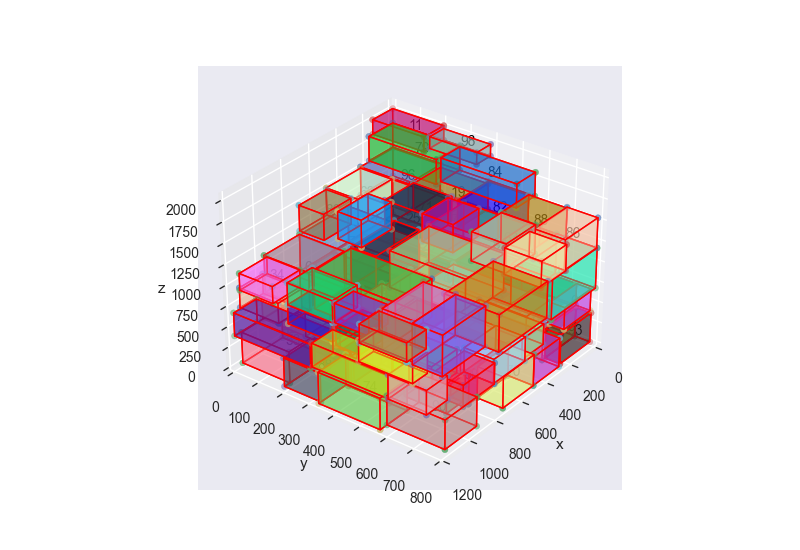

<IPython.core.display.Javascript object>


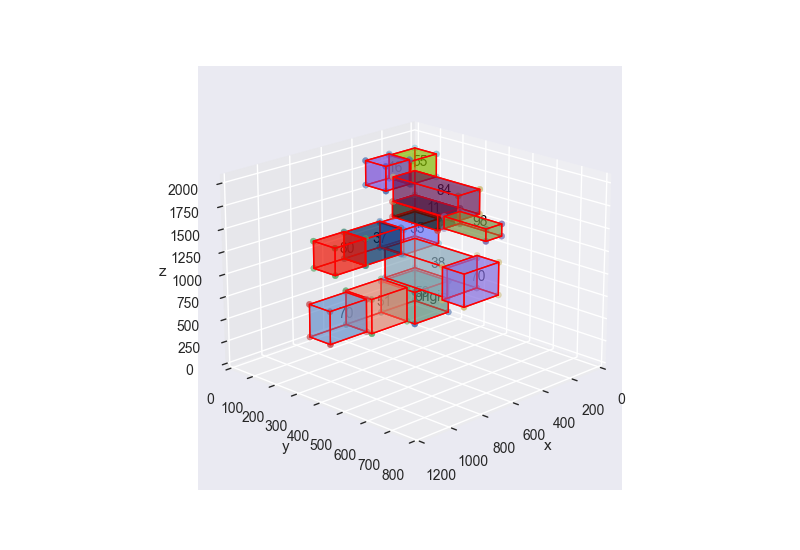

<IPython.core.display.Javascript object>


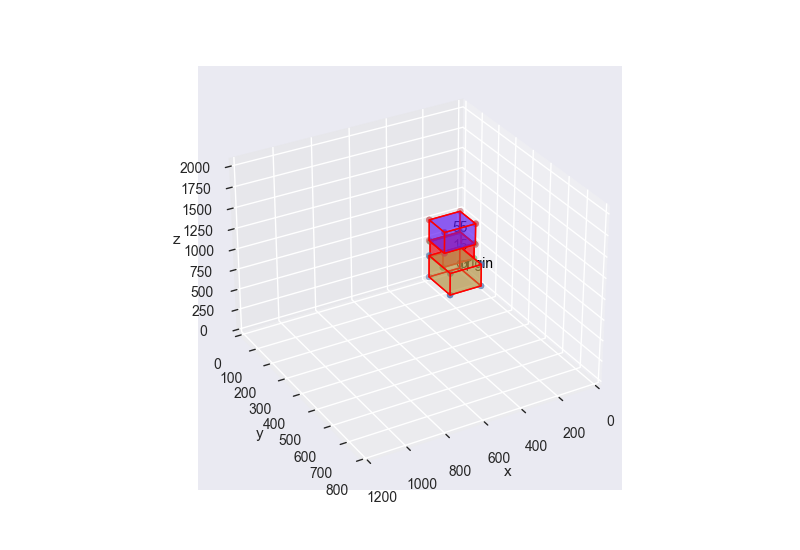

<IPython.core.display.Javascript object>

In [115]:
bin_pool.plot()
# print([b.layer_pool.get_ol() for b in bin_pool])
# print([l.superitems_pool for b in bin_pool for l in b.layer_pool])

## Column generation

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?

In [64]:
order.iloc[[10, 17, 21, 46]]

,id,width,depth,height,weight,volume
10,870910,307,167,422,2,21635518
17,65725,324,98,472,2,14986944
21,905778,317,110,484,2,16877080
46,251995,307,187,387,39,22217283


<IPython.core.display.Javascript object>

In [70]:
bins_lbs = []
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for i, spool in enumerate([height_groups[101]]):
    print(f"Height group {i + 1}/{len(height_groups)}")
    print(spool)
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    print(layer_pool)
    layer_pool, bins_lb = cg.column_generation(
        layer_pool,
        config.PALLET_DIMS,
        max_iter=100,
        max_stag_iters=5,
        tlim=None,
        use_maxrect=True,
    )
    final_layer_pool.extend(layer_pool)
    bins_lbs.append(bins_lb)

final_layer_pool.to_dataframe()

  5%|▌         | 5/100 [00:00<00:00, 246.50it/s]

Height group 1/103
SuperitemPool(superitems=[Superitem(ids=[10, 17, 21, 46], width=324, depth=187, height=1765, weight=45, volume=75716825, coords={10: Coordinate(x=8, y=10, z=0), 46: Coordinate(x=8, y=0, z=422), 21: Coordinate(x=3, y=38, z=809), 17: Coordinate(x=0, y=44, z=1293)})])
LayerPool(layers=[Layer(height=1765, ids=[10, 17, 21, 46])])
Solving RMP...
Duals: [1765.   -0.   -0.   -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 1766.0
Reduced cost: -0.0016987542469451
Solving RMP...
Duals: [  -0.   -0.   -0. 1765.]
Alpha: [1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 1766.0
Reduced cost: -0.0016987542469451
Solving RMP...
Duals: [  -0.   -0.   -0. 1765.]
Alpha: [1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 1766.0
Reduced cost: -0.0016987542469451
Solving RMP...
Duals: [  -0.   -0.   -0. 1765.]
Alpha: [1

,item,x,y,z,width,depth,height,layer
0,10,8,10,0,307,167,422,0
1,46,8,0,422,307,187,387,0
2,21,3,38,809,317,110,484,0
3,17,0,44,1293,324,98,472,0
4,10,8,10,0,307,167,422,1
5,46,8,0,422,307,187,387,1
6,21,3,38,809,317,110,484,1
7,17,0,44,1293,324,98,472,1
8,10,8,10,0,307,167,422,2
9,46,8,0,422,307,187,387,2


<IPython.core.display.Javascript object>

In [15]:
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH, config.PALLET_DEPTH, min_density=0.0, max_coverage=3
)

<IPython.core.display.Javascript object>

In [16]:
final_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,20,0,0,0,232,494,441,0
1,56,0,494,0,350,287,441,0
2,21,232,0,0,343,263,411,0
3,39,232,263,0,340,192,413,0
4,51,350,455,0,300,291,444,0
...,...,...,...,...,...,...,...,...
72,36,193,119,0,243,102,406,5
73,66,226,0,0,242,109,289,6
74,68,468,0,0,240,97,304,6
75,70,242,0,0,234,112,251,7


<IPython.core.display.Javascript object>

In [17]:
np.floor(np.mean(bins_lbs) / config.PALLET_HEIGHT)

0.0

<IPython.core.display.Javascript object>

In [18]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer,bin
0,20,0,0,0,232,494,441,0,0
1,56,0,494,0,350,287,441,0,0
2,21,232,0,0,343,263,411,0,0
3,39,232,263,0,340,192,413,0,0
4,51,350,455,0,300,291,444,0,0
...,...,...,...,...,...,...,...,...,...
1,36,193,119,0,243,102,406,0,1
2,66,226,0,417,242,109,289,1,1
3,68,468,0,417,240,97,304,1,1
4,70,242,0,744,234,112,251,2,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


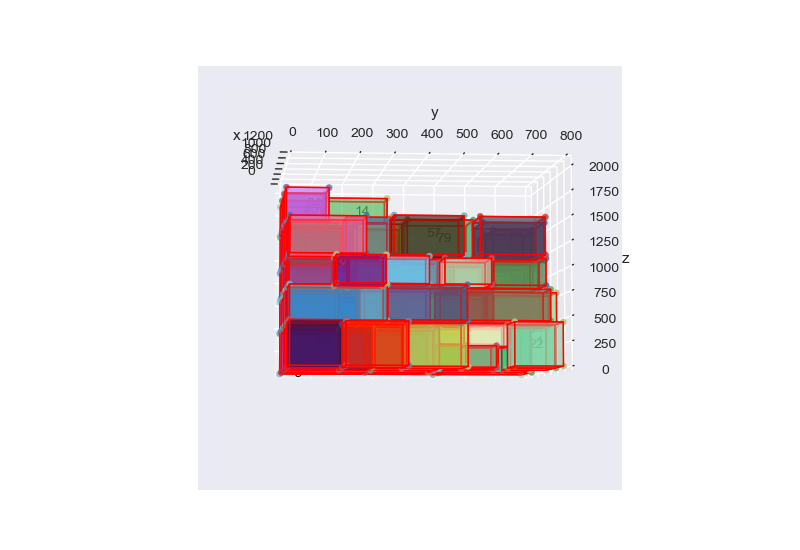

<IPython.core.display.Javascript object>


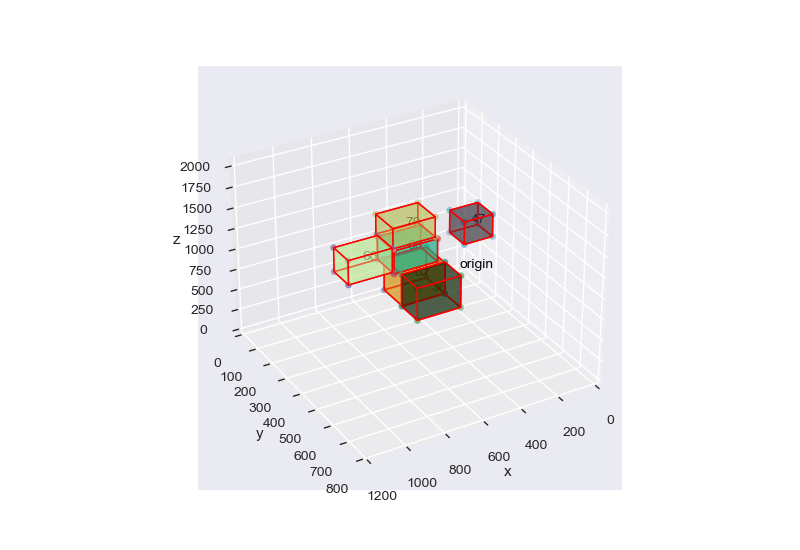

<IPython.core.display.Javascript object>

In [19]:
bin_pool.plot()

Generating vertical superitems: 100%|██████████| 24/24 [00:00<00:00, 375609.31it/s]


Height group 1/48
Height group 2/48
Height group 3/48
Height group 4/48
Height group 5/48
Height group 6/48
Height group 7/48
Height group 8/48
Height group 9/48
Height group 10/48
Height group 11/48
Height group 12/48
Height group 13/48
Height group 14/48
Height group 15/48
Height group 16/48
Height group 17/48
Height group 18/48
Height group 19/48
Height group 20/48
Height group 21/48
Height group 22/48
Height group 23/48
Height group 24/48
Height group 25/48
Height group 26/48
Height group 27/48
Height group 28/48
Height group 29/48
Height group 30/48
Height group 31/48
Height group 32/48
Height group 33/48
Height group 34/48
Height group 35/48
Height group 36/48
Height group 37/48
Height group 38/48
Height group 39/48
Height group 40/48
Height group 41/48
Height group 42/48
Height group 43/48
Height group 44/48
Height group 45/48
Height group 46/48
Height group 47/48
Height group 48/48
Items not covered: 33/100


<IPython.core.display.Javascript object>


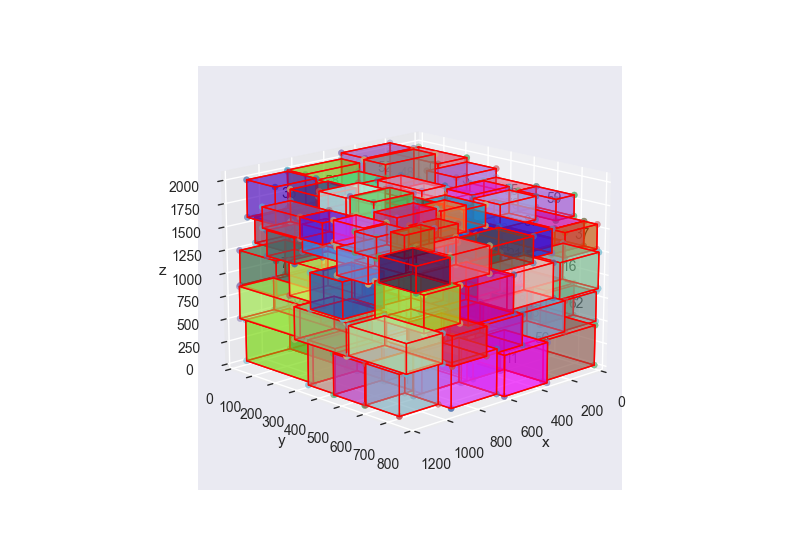

<IPython.core.display.Javascript object>


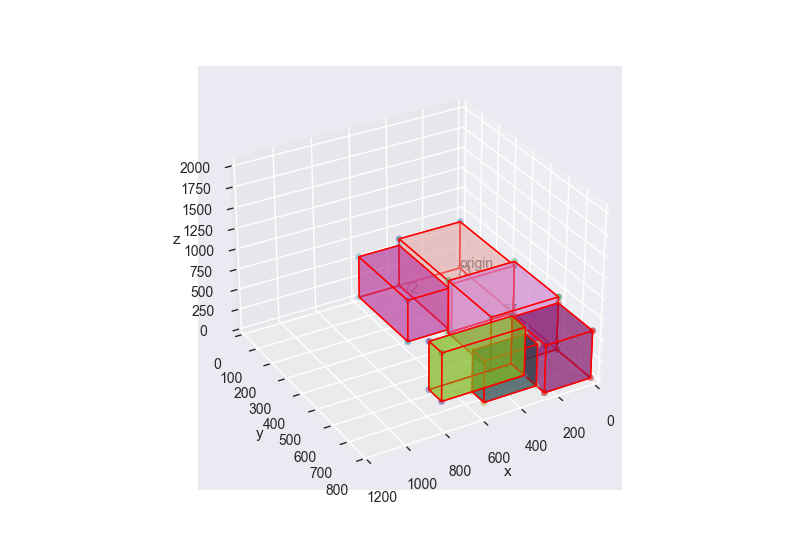

<IPython.core.display.Javascript object>

In [9]:
from src import main

mr_layer_pool, bins_lbs = main.main(order, use_cg=False)
mr_bin_pool = pack.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

In [ ]:
from src import main
from time import time

start = time()
cg_layer_pool, bins_lbs = main.main(order, use_cg=True, tlim=None)
total = time() - start
print("TOTAL TIME", total)
cg_bin_pool = pack.BinPool(cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

Generating vertical superitems: 100%|██████████| 150/150 [00:00<00:00, 807632.35it/s]


Height group 1/456
Iteration 1/100
Solving RMP...
RMP objective: 202.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 202.]
RMP time: 0.015
Alpha: [1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 225.0
SP no placement time: 0.019
Reduced cost: -13.75999999999948
Iteration 2/100
Solving RMP...
RMP objective: 202.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0. 202.  -0.  -0.]
RMP time: 0.025
Alpha: [1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 225.0
SP no placement time: 0.02
Reduced cost: -7.0533333333328
Iteration 3/100
Solving RMP...
RMP objective: 202.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 202.  -0.  -0.  -0.  -0.]
RMP time: 0.034
Alpha: [1.0, 0.0, 0.0]
Solving SP (no placement)...
Rewa

RMP objective: 410.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 191.  -0. 219.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 0.15
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 226.0
SP no placement time: 0.042
Reduced cost: -196.11061946902677
Iteration 5/100
Solving RMP...
RMP objective: 410.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  19.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 191.  -0. 196.  -0.  -0.  -0.
  -0.  -0.  -0.   4.  -0.  -0.  -0.]
RMP time: 0.172
Alpha: [1.0, 1.0, -0.0, -0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 39.00000000000001
SP no placement time: 0.049
Reduced cost: -218.8205128205126
Iteration 6/100
Solving RMP...
RMP objective: 410.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  19.  -0.  -0.  -0. 

RMP objective: 437.0
Duals: [ -0.  -0.  -0.  -0.  17.  -0. 210.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 210.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 0.227
Alpha: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 54.999999999999986
SP no placement time: 0.094
Reduced cost: -237.7272727272734
Iteration 7/100
Solving RMP...
RMP objective: 437.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0. 210.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.   9.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 201.  -0.  17.  -0.  -0.  -0.  -0.  -0.  -0.]
RMP time: 0.267
Alpha: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 47.000000000000014
SP no placement time: 0.052
Reduced cost: -235.31914893617102
Iteration 8/100
Solving RMP...
RMP objective: 437.0
Duals

RMP objective: 468.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 234.  -0.  -0.  -0. 234.  -0.
  -0.]
RMP time: 0.131
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 277.0
SP no placement time: 0.067
Reduced cost: -239.32851985559412
Iteration 3/100
Solving RMP...
RMP objective: 468.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 234.  -0.
  -0.  -0.  -0.  -0. 234.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.]
RMP time: 0.205
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 277.0
SP no placement time: 0.087
Reduced cost: -239.18050541516095
Iteration 4/100
Solving RMP...
RMP objective: 468.0
Duals: [ -0.  -0. 

SP no placement time: 0.128
Reduced cost: -267.51748251748296
Iteration 2/100
Solving RMP...
RMP objective: 479.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 239.  -0.
  -0. 240.  -0.  -0.  -0.]
RMP time: 0.151
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 286.0
SP no placement time: 0.071
Reduced cost: -249.34965034965094
Iteration 3/100
Solving RMP...
RMP objective: 479.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0. 239.  -0.  -0.  -0. 240.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
RMP time: 0.201
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 286.0

RMP objective: 736.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 243. 247.
  -0. 246.]
RMP time: 0.224
Alpha: [1.0, 1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 301.0
SP no placement time: 0.161
Reduced cost: -499.7607973421921
Iteration 2/100
Solving RMP...
RMP objective: 736.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 247.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 243.  -0.
 246.  -0.]
RMP time: 0.294
Alpha: [1.0, 1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, 

RMP objective: 745.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  10.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 249.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 237.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 249.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.]
RMP time: 0.504
Alpha: [1.0, 1.0, 1.0, 0.0, -0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 69.99999999999999
SP no placement time: 0.181
Reduced cost: -526.3999999999984
Iteration 5/100
Solving RMP...
RMP objective: 745.0
Duals: [ -0.  -0.  -0.  10.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0. 249.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 237.  -0.  -0.  -0.  -0.  -0.  -0. 249.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.]
RMP time: 0.532
Alpha: [1.0, 1.0, 1.0, 0.0, -0.0, 0.0, 0.0]
Solving SP (no 

RMP objective: 765.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 255.  -0. 255. 255.]
RMP time: 0.309
Alpha: [1.0, 1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 325.0
SP no placement time: 0.201
Reduced cost: -520.2461538461531
Iteration 2/100
Solving RMP...
RMP objective: 765.0
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 255. 255.  -0.  -0. 255.  -0.]
RMP

In [125]:
from rectpack import newPacker, PackingMode, PackingBin, SORT_AREA
from rectpack.maxrects import MaxRectsBaf

# Create the maxrects packing algorithm
packer = newPacker(
    mode=PackingMode.Offline,
    bin_algo=PackingBin.Global,
    pack_algo=MaxRectsBaf,
    sort_algo=SORT_AREA,
    rotation=False,
)

# Add one bin representing one layer
packer.add_bin(100, 100, count=1)

packer.add_rect(10, 10, rid=0)
packer.add_rect(50, 50, rid=1)
packer.add_rect(60, 60, rid=2)

# Start the packing procedure
packer.pack()

packer.rect_list()

[(0, 0, 0, 60, 60, 2), (0, 60, 0, 10, 10, 0)]

<IPython.core.display.Javascript object>

## Todo 

### Problemi in Input al modello:
- [ ] Correggere gestione superitem in Heigth groups
    - Problema riguardo stesso Item nello stesso Layer dovuto a superitem Horizontal nei 2 assi -> (Messo in pausa, per ora risolto usando solo Vertical e Single superitems)
    - Suddividere gruppi in piu gruppi 
        - Solo fra superitem con > 1 item e superitem con = 1 item
- [x] Eliminare gruppi con 1 solo item e gruppi con densita minore di 0.5
- [x] Creare Vertical Superitems consistenti alla loro dimensione principale (Da rivedere in caso di aggiunta rotazione, come tutto...)
- [x] Corretto calcolo volume Superitems e aggiunto enclosing_volume per Vertical Superitems
- [ ] Rivedere lower bound martello (L1 viene 0) (L0 corretto) (L2 troppo lento)

### Problemi interni al modello:
- [x] Aggiunto reward in pricing_no_placement per incetivare la costruzione di layer più densi -> Con più item, quindi anche di item con Dual[i]==0, formula di reward con upper_bound = min(dual[i] !=0)
- [x] Modificato pricing placement (v2) per piazzare tutti gli item selezionati se possibile -> Molto lento con 13 item muore ma corretto rispetto a v1 che tendeva per costruzione a non piazzare tutta la sottoparte selezionata
- [x] Aggiunto maxrect placement per i nuovi layer del column generation

    
### Problemi in Output al modello:
- [ ] Aggiungere gestione Weigth a quella della Densità con qualche priorità e spiegazione annessa
- [x] Aggiungere gestione coordinate corretta per i Vertical Superitems, centrare gli oggetti nello spazio occupato
- [x] Controllare select_layer e aggiungere flag per utilizzare solo subset di sottoprocess per testing
- [ ] Sostituire item rimossi in fase di select_layers con altri item non piazzati, usando maxrects
    - [x] per ora: rearrange con maxrects e re-iterazione di tutto il processo con gli item non piazzati
- [x] Gestione Item rimanenti
    1. Piazzare gli ultimi item con algoritmo s-shape
    2. Provare a suddividere lo spazio rimanente in alto anche di layer incompleti in "Sotto pallet" ed usare maxrect su quelli (Magari funziona meglio)
- [ ] Gestione spaziatura 
    - Spaziatura intra-layer spiegata nel paper?
        1. 2 modelli di linear programming -> Spaziatura mediante modelli per width and depth dimensions
        2. Soluzione di spostamento monodirezionale iterativa dei blocchi di un layer (Da pensare per bene come alternativa a 1)
    - Spaziatura inter-layer in altezza
         1. Controllare spazi vuoti anche in altezza al termine di tutto usando una delle 2 tecnice sopradescritte
         
### Aggiunte eventuali
- [ ] Gestione rotazione
- [ ] Oggetti fragili -> Peso + attributi particolari


## TODO tomorrow
- Finire s-shaped
    - Rivedere caso piu di un layer in nuovo bin
- Convertire oggetti in immutabili
    - "If layer in self.layers" lento -> fare come in superitems?
- Solver e search strategy per column generation
    - Provato GLOP invece di CLP in RMP -> no change
    - Da provare: rimuovere SP quando si usa maxrects -> ordinare items in base ai duali e chiamare maxrects (packing effettuato su cosa ci entra nel layer)
- Rivedere lower bound
- Spaziatura